In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler , RobustScaler
from sklearn.model_selection import train_test_split ,KFold , cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC , SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest , f_classif ,RFE
from scipy.stats.mstats import winsorize


In [2]:
def get_boundaries(df,column_name):

    # finding IQR
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # getting upper&lower bound
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR

    return upper,lower

In [3]:
def sigmoid(z):
    return 1 / (1+ np.exp(-z))

In [4]:
def gradient_descent(X,Y,n_iter,alpha):
    X = np.array(X)
    Y = np.array(Y).reshape(-1, 1)  # Ensure Y has shape (m, 1)
    num_of_features = X.shape[1]
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    theta = np.random.rand(num_of_features + 1, 1)

    for i in range(n_iter):
        gradients = (2/X.shape[0]) * X_b.T.dot(X_b.dot(theta) - Y)
        theta = theta -  alpha * gradients

    return theta

In [5]:
def predict(X,theta):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    z = X_b.dot(theta)
    h_x = sigmoid(z)

    # return binary classiffication 0,1
    prediction = (h_x>=0.5).astype(int)

    return prediction

## Loading data

In [6]:
df = pd.read_csv('/content/heart.csv')

In [7]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [8]:
# data shape
df.shape

(918, 12)

In [9]:
# data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [10]:
# check for null values
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [11]:
# check for dublicates
df.duplicated().sum()

0

In [12]:
# check unique values for catagorical columns
print('unique values for categorical columns.')
print()
print('ChestPainType: ',df['ChestPainType'].unique())
print('RestingECG: ', df['RestingECG'].unique())
print('ST_Slope: ',df['ST_Slope'].unique())
print('ExerciseAngina: ', df['ExerciseAngina'].unique())
print('Sex: ', df['Sex'].unique())

unique values for categorical columns.

ChestPainType:  ['ATA' 'NAP' 'ASY' 'TA']
RestingECG:  ['Normal' 'ST' 'LVH']
ST_Slope:  ['Up' 'Flat' 'Down']
ExerciseAngina:  ['N' 'Y']
Sex:  ['M' 'F']


## Some EDA

In [13]:
# number of males that have heart disease
male_counts = df[(df['Sex']=='M') & (df['HeartDisease']==1)].shape[0]

In [14]:
# numbers of females that have heart disease
female_counts = df[(df["Sex"]=='F') & (df['HeartDisease']==1)].shape[0]

In [15]:
print('Numbers of males with Heart Disease: ', male_counts)
print("Number of females with Heart Disease: ", female_counts)

Numbers of males with Heart Disease:  458
Number of females with Heart Disease:  50


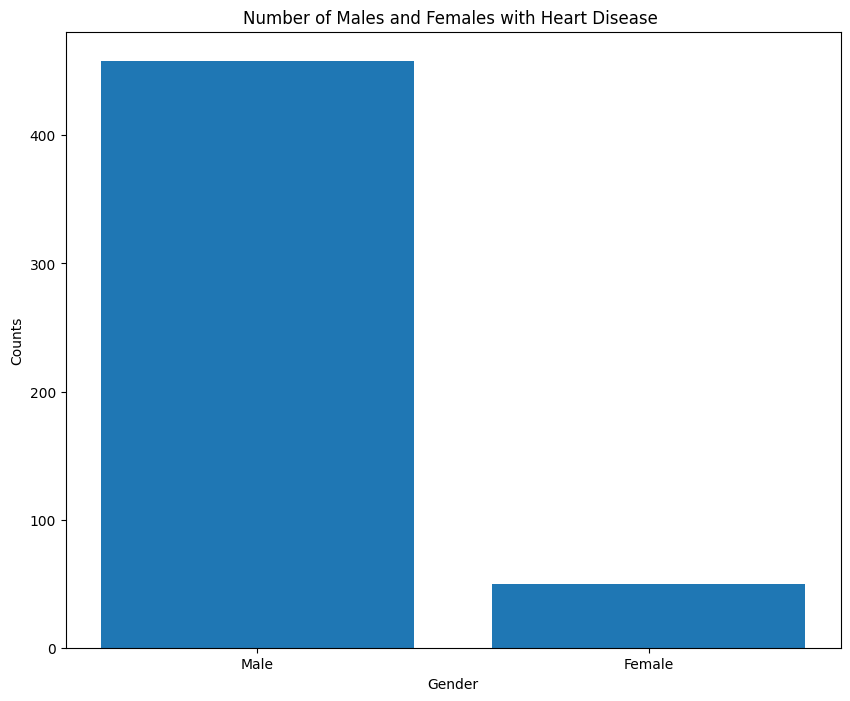

In [16]:
plt.figure(figsize=(10,8))
plt.bar(['Male', 'Female'], [male_counts,female_counts])
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Number of Males and Females with Heart Disease ')
plt.show()

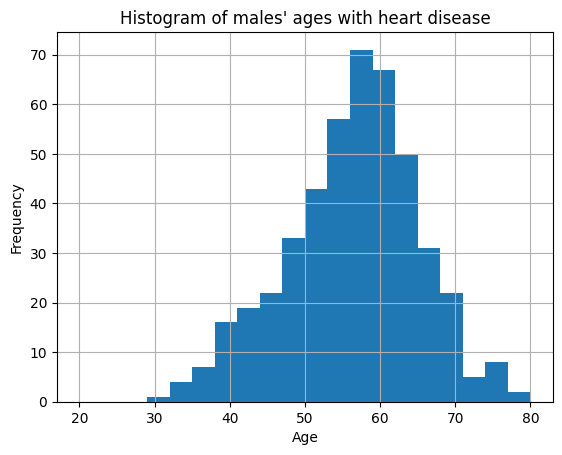

In [17]:
# most males ages with Heart Disease

df[(df['Sex']=='M') & (df['HeartDisease']==1)].hist('Age',bins=20,range=[20,80])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title("Histogram of males' ages with heart disease")
plt.show()

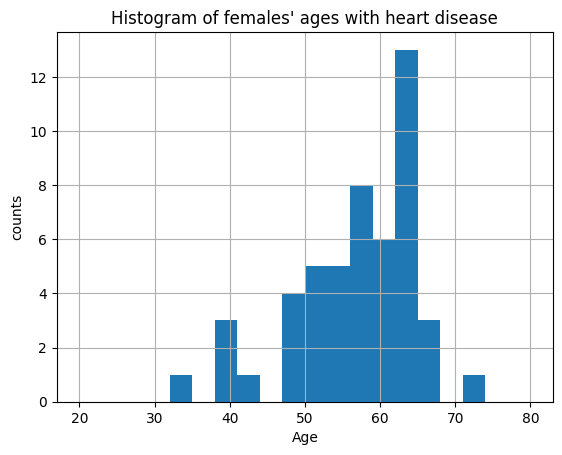

In [18]:
# most female ages with heart disease
df[(df['Sex']=='F') & (df['HeartDisease']==1)].hist('Age',bins=20,range=[20,80])
plt.xlabel('Age')
plt.ylabel('counts')
plt.title("Histogram of females' ages with heart disease")
plt.show()

In [19]:
# number of people who have heart disease and not
heartDisease_counts = df[df['HeartDisease']==1].shape[0]
withNoHeartDisease_count = df[df['HeartDisease']==0].shape[0]


In [20]:
print('Number of people with heart Disease: ', heartDisease_counts)
print('Number of people without Heart Disease: ',withNoHeartDisease_count)

Number of people with heart Disease:  508
Number of people without Heart Disease:  410


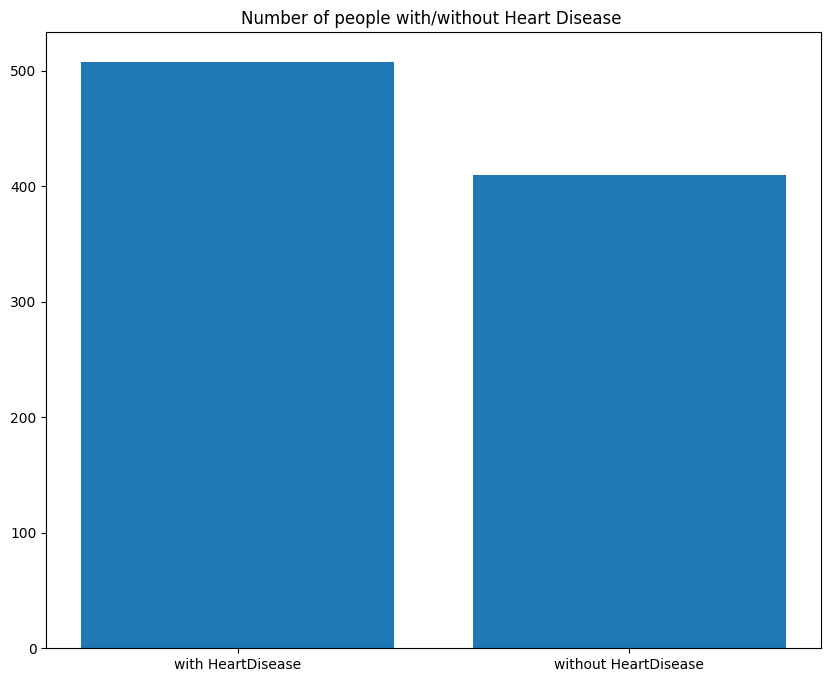

In [21]:
plt.figure(figsize=(10,8))
plt.bar(['with HeartDisease', 'without HeartDisease'],[heartDisease_counts,withNoHeartDisease_count])
plt.title('Number of people with/without Heart Disease ')
plt.show()

## train/test split

In [22]:
X = df.drop('HeartDisease',axis=1)
y = df['HeartDisease']

In [23]:
x_train , x_test , y_train , y_test = train_test_split(X,y , shuffle=True, test_size=0.2,random_state=40)

## preprocessing on training data set

### 1- Outliers handling (Winsorization)

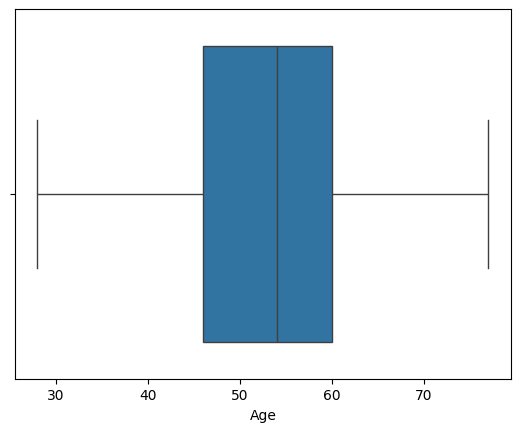

In [24]:
# checking for outliers in Age column
sns.boxplot(x=x_train['Age'])
plt.show()

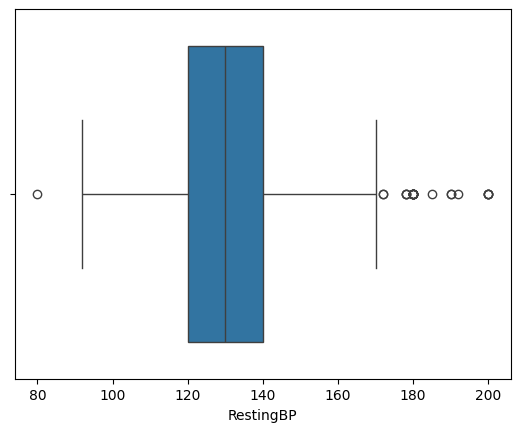

In [25]:
# checking for outliers in restingBP column
sns.boxplot(x=x_train['RestingBP'])
plt.show()

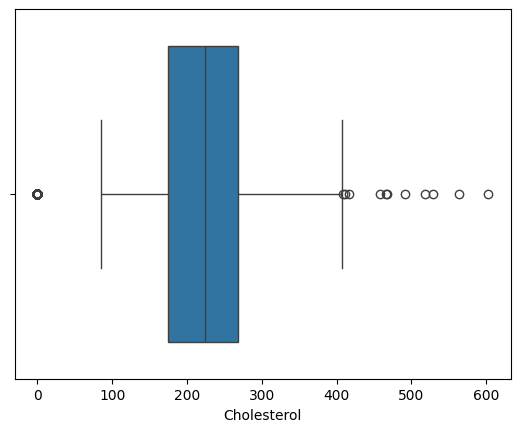

In [26]:
# checking for outliers in Cholesterol column
sns.boxplot(x=x_train['Cholesterol'])
plt.show()

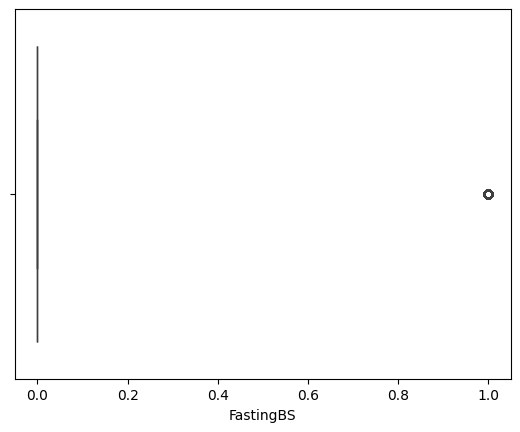

In [27]:
# checking for outliers in FastingBS column
sns.boxplot(x=x_train['FastingBS'])
plt.show()

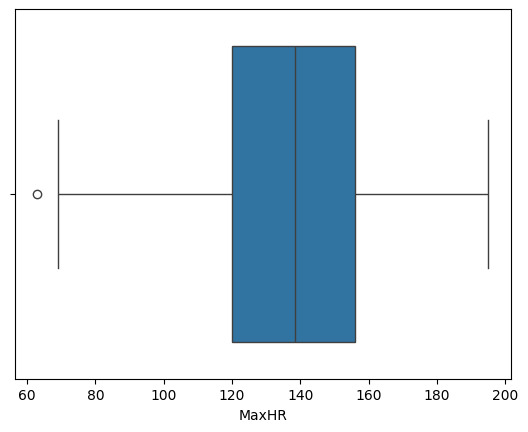

In [28]:
# checking for outliers in MaxHR column
sns.boxplot(x=x_train['MaxHR'])
plt.show()

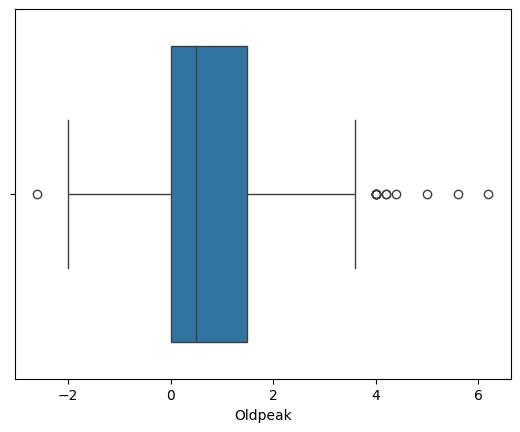

In [29]:
# checking for outliers in Oldpeak column
sns.boxplot(x=x_train['Oldpeak'])
plt.show()

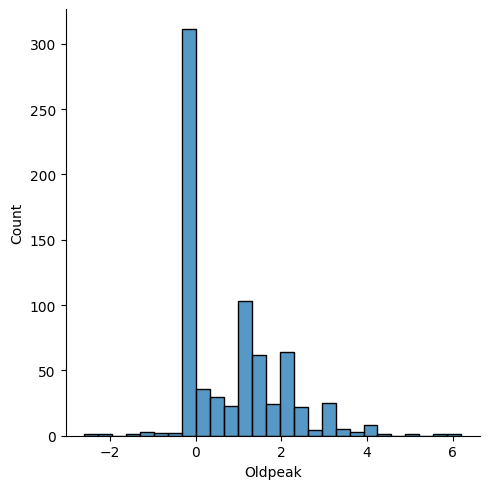

In [30]:
sns.displot(x_train['Oldpeak'],)
plt.show()

In [31]:
'''
# getting upper & lower bounds for each column that has outliers
upper_oldpeak , lower_oldpeak = get_boundaries(x_train,'Oldpeak')
upper_maxHR , lower_maxHR = get_boundaries(x_train,'MaxHR')
upper_fastingBS , lower_fastingBS = get_boundaries(x_train,'FastingBS')
upper_cholesterol , lower_cholesterol = get_boundaries(x_train,'Cholesterol')
upper_restingBP , lower_restingBP = get_boundaries(x_train,'RestingBP')
'''

"\n# getting upper & lower bounds for each column that has outliers\nupper_oldpeak , lower_oldpeak = get_boundaries(x_train,'Oldpeak')\nupper_maxHR , lower_maxHR = get_boundaries(x_train,'MaxHR')\nupper_fastingBS , lower_fastingBS = get_boundaries(x_train,'FastingBS')\nupper_cholesterol , lower_cholesterol = get_boundaries(x_train,'Cholesterol')\nupper_restingBP , lower_restingBP = get_boundaries(x_train,'RestingBP')\n"

In [32]:
'''
print('oldpeak upper&lower bounds: ', upper_oldpeak,',',lower_oldpeak)
print('maxHR upper&lower bounds: ', upper_maxHR,',',lower_maxHR)
print('fastingBS upper&lower bounds: ', upper_fastingBS,',',lower_fastingBS)
print('Cholesterol upper&lower bounds: ', upper_cholesterol,',' , lower_cholesterol)
print('RestingBP upper&lower bounds: ', upper_restingBP ,',', lower_restingBP)
'''

"\nprint('oldpeak upper&lower bounds: ', upper_oldpeak,',',lower_oldpeak)\nprint('maxHR upper&lower bounds: ', upper_maxHR,',',lower_maxHR)\nprint('fastingBS upper&lower bounds: ', upper_fastingBS,',',lower_fastingBS)\nprint('Cholesterol upper&lower bounds: ', upper_cholesterol,',' , lower_cholesterol)\nprint('RestingBP upper&lower bounds: ', upper_restingBP ,',', lower_restingBP)\n"

In [33]:
'''# capping outliers with lower&upper bounds
x_train['Oldpeak'] = np.where(x_train['Oldpeak']> upper_oldpeak, upper_oldpeak,
                        np.where(x_train['Oldpeak']<lower_oldpeak,lower_oldpeak, x_train['Oldpeak']))
x_train['MaxHR'] = np.where(x_train['MaxHR']>upper_maxHR , upper_maxHR,
                      np.where(x_train['MaxHR']< lower_maxHR , lower_maxHR , x_train['MaxHR']))
x_train['FastingBS'] = np.where(x_train['FastingBS']>upper_fastingBS , upper_fastingBS,
                          np.where(x_train['FastingBS']< lower_fastingBS , lower_fastingBS , x_train['FastingBS']))
x_train['Cholesterol'] = np.where(x_train['Cholesterol']>upper_cholesterol, upper_cholesterol,
                            np.where(x_train['Cholesterol']<lower_cholesterol,lower_cholesterol , x_train['Cholesterol']))
x_train['RestingBP'] = np.where(x_train['RestingBP']> upper_restingBP , upper_restingBP,
                          np.where(x_train['RestingBP']< lower_restingBP , lower_restingBP , x_train['RestingBP']))'''

"# capping outliers with lower&upper bounds\nx_train['Oldpeak'] = np.where(x_train['Oldpeak']> upper_oldpeak, upper_oldpeak,\n                        np.where(x_train['Oldpeak']<lower_oldpeak,lower_oldpeak, x_train['Oldpeak']))\nx_train['MaxHR'] = np.where(x_train['MaxHR']>upper_maxHR , upper_maxHR,\n                      np.where(x_train['MaxHR']< lower_maxHR , lower_maxHR , x_train['MaxHR']))\nx_train['FastingBS'] = np.where(x_train['FastingBS']>upper_fastingBS , upper_fastingBS,\n                          np.where(x_train['FastingBS']< lower_fastingBS , lower_fastingBS , x_train['FastingBS']))\nx_train['Cholesterol'] = np.where(x_train['Cholesterol']>upper_cholesterol, upper_cholesterol,\n                            np.where(x_train['Cholesterol']<lower_cholesterol,lower_cholesterol , x_train['Cholesterol']))\nx_train['RestingBP'] = np.where(x_train['RestingBP']> upper_restingBP , upper_restingBP,\n                          np.where(x_train['RestingBP']< lower_restingBP , lower_rest

In [34]:
'''
# log tranformation for handeling outliers
x_train[['Oldpeak']] = np.log1p(x_train[['Oldpeak']] + 2.61)
x_train['MaxHR'] = np.log1p(x_train['MaxHR'])
x_train['FastingBS'] = np.log1p(x_train['FastingBS']+ 0.001)
x_train['Cholesterol'] = np.log1p(x_train['Cholesterol'] + 0.001)
x_train['RestingBP'] = np.log1p(x_train['RestingBP'])
'''

"\n# log tranformation for handeling outliers\nx_train[['Oldpeak']] = np.log1p(x_train[['Oldpeak']] + 2.61)\nx_train['MaxHR'] = np.log1p(x_train['MaxHR'])\nx_train['FastingBS'] = np.log1p(x_train['FastingBS']+ 0.001)\nx_train['Cholesterol'] = np.log1p(x_train['Cholesterol'] + 0.001)\nx_train['RestingBP'] = np.log1p(x_train['RestingBP'])\n"

In [35]:
# Winsorization
percentile_limits = [0.05, 0.05] #(replace values below 5th percentile and above 95th percentile)

x_train['Oldpeak'] = winsorize(x_train['Oldpeak'],limits=percentile_limits)
x_train['MaxHR'] = winsorize(x_train['MaxHR'] , limits=percentile_limits)
x_train['FastingBS'] = winsorize(x_train['FastingBS'] , limits=percentile_limits)
x_train['Cholesterol'] = winsorize(x_train['Cholesterol'] , limits=percentile_limits)
x_train['RestingBP'] = winsorize(x_train['RestingBP'] , limits=percentile_limits)

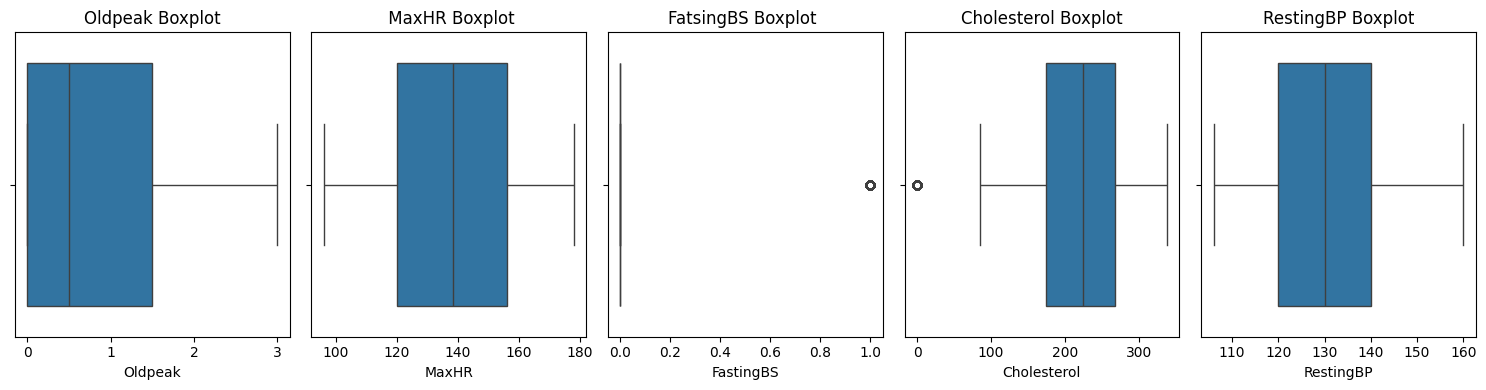

In [36]:
# Create a figure with 5 subplots in a single row
fig, axs = plt.subplots(1, 5, figsize=(15, 4))

# Plot boxplots on each subplot using Seaborn
sns.boxplot(x=x_train['Oldpeak'], ax=axs[0])
axs[0].set_title('Oldpeak Boxplot')

sns.boxplot(x= x_train['MaxHR'] , ax=axs[1])
axs[1].set_title(' MaxHR Boxplot')

sns.boxplot(x= x_train['FastingBS'] , ax=axs[2])
axs[2].set_title('FatsingBS Boxplot ')

sns.boxplot(x=x_train['Cholesterol'], ax=axs[3])
axs[3].set_title('Cholesterol Boxplot')

sns.boxplot(x=x_train['RestingBP'], ax=axs[4])
axs[4].set_title('RestingBP Boxplot')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### 2- Scaling numerical data

In [37]:
scaler = StandardScaler()

In [38]:
numerical_features = ['Age','RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

In [39]:
data_to_scale = x_train[numerical_features]

In [40]:
scaled_data = scaler.fit_transform(data_to_scale)

In [41]:
x_train[numerical_features] = scaled_data

In [42]:
x_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
658,-0.765535,M,ATA,-1.669279,-0.022166,1.773948,Normal,0.781501,N,-0.875965,Up
501,1.011976,M,ASY,-0.112664,1.050902,-0.563714,Normal,0.022352,Y,1.210545,Flat
907,-0.974654,M,ASY,-0.761253,-0.292850,-0.563714,Normal,0.275401,Y,2.045149,Down
366,0.802857,M,ASY,1.184515,-1.926622,-0.563714,Normal,-0.863322,Y,1.210545,Flat
812,0.070941,F,NAP,-1.409843,0.142178,-0.563714,Normal,0.865851,N,0.793243,Flat


### 3- encoding categorical  features

In [43]:
# categorical Features
categorical_features = ['Sex','ChestPainType', 'RestingECG', 'ExerciseAngina','ST_Slope' ]

In [44]:
x_train = pd.get_dummies(x_train , columns=categorical_features, drop_first=True)

In [45]:
x_train.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
658,-0.765535,-1.669279,-0.022166,1.773948,0.781501,-0.875965,1,1,0,0,1,0,0,0,1
501,1.011976,-0.112664,1.050902,-0.563714,0.022352,1.210545,1,0,0,0,1,0,1,1,0
907,-0.974654,-0.761253,-0.292850,-0.563714,0.275401,2.045149,1,0,0,0,1,0,1,0,0
366,0.802857,1.184515,-1.926622,-0.563714,-0.863322,1.210545,1,0,0,0,1,0,1,1,0
812,0.070941,-1.409843,0.142178,-0.563714,0.865851,0.793243,0,0,1,0,1,0,0,1,0


### 3- Feature selection

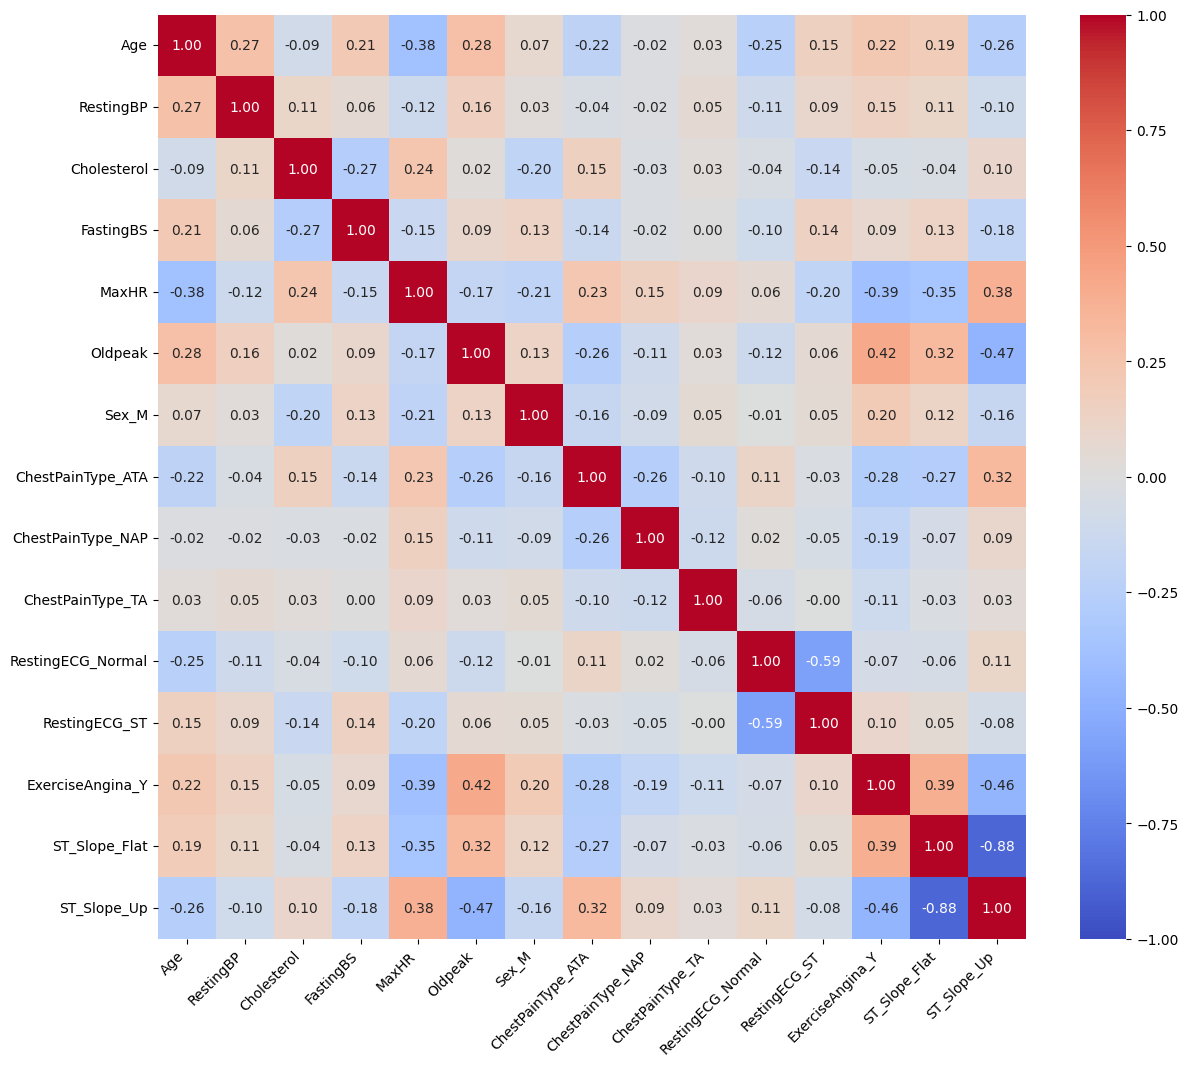

In [46]:
# correlation matrix
correlation_matrix = x_train.corr()
# Set up the matplotlib figure
plt.figure(figsize=(14, 12))


sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha="right")

# Rotate the y-axis labels
plt.yticks(rotation=0)

# Display the plot
plt.show()

**SelectKbest**

In [47]:
selector = SelectKBest(score_func=f_classif , k=10)
x_trin_best = selector.fit_transform(x_train,y_train)

In [48]:
kbest_scores = selector.scores_

In [49]:
# indices of the slected features
selector.get_support(indices=True)

array([ 0,  3,  4,  5,  6,  7,  8, 12, 13, 14])

In [50]:
pd.DataFrame({'features':x_train.columns, 'scores': kbest_scores}).sort_values(by='scores', ascending=False).head(10)

,features,scores
14,ST_Slope_Up,426.184775
13,ST_Slope_Flat,305.779921
12,ExerciseAngina_Y,238.528112
5,Oldpeak,157.805055
4,MaxHR,146.952426
7,ChestPainType_ATA,110.022466
6,Sex_M,81.605492
0,Age,71.148450
3,FastingBS,68.609175
8,ChestPainType_NAP,41.885754


## preprocessing test data

### 1- Winsorization


In [51]:
x_test['Oldpeak'] = winsorize(x_test['Oldpeak'],limits=percentile_limits)
x_test['MaxHR'] = winsorize(x_test['MaxHR'] , limits=percentile_limits)
x_test['FastingBS'] = winsorize(x_test['FastingBS'] , limits=percentile_limits)
x_test['Cholesterol'] = winsorize(x_test['Cholesterol'] , limits=percentile_limits)
x_test['RestingBP'] = winsorize(x_test['RestingBP'] , limits=percentile_limits)

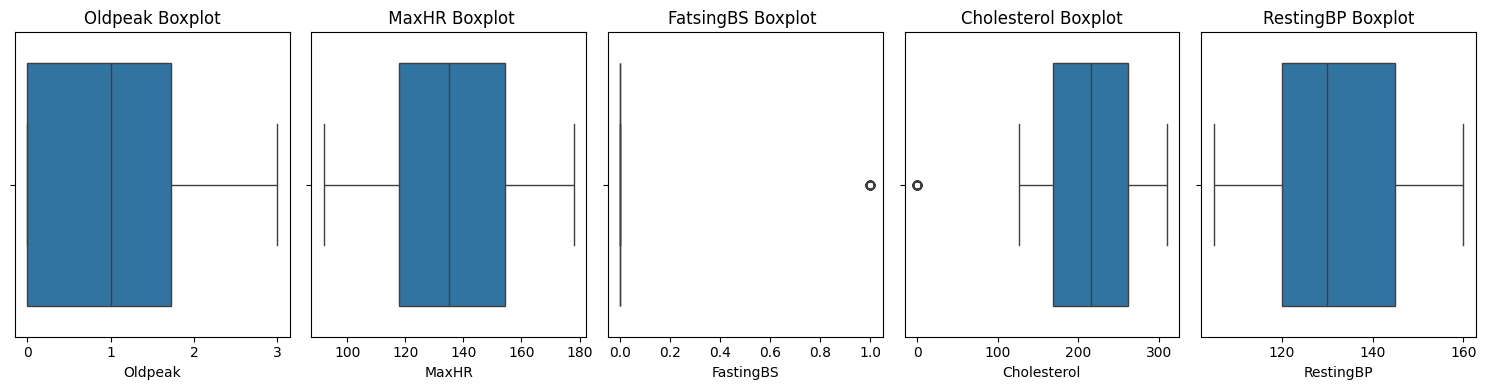

In [52]:
# Create a figure with 5 subplots in a single row
fig, axs = plt.subplots(1, 5, figsize=(15, 4))

# Plot boxplots on each subplot using Seaborn
sns.boxplot(x=x_test['Oldpeak'], ax=axs[0])
axs[0].set_title('Oldpeak Boxplot')

sns.boxplot(x= x_test['MaxHR'] , ax=axs[1])
axs[1].set_title(' MaxHR Boxplot')

sns.boxplot(x= x_test['FastingBS'] , ax=axs[2])
axs[2].set_title('FatsingBS Boxplot ')

sns.boxplot(x=x_test['Cholesterol'], ax=axs[3])
axs[3].set_title('Cholesterol Boxplot')

sns.boxplot(x=x_test['RestingBP'], ax=axs[4])
axs[4].set_title('RestingBP Boxplot')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### 2- scaling numerical Feature

In [53]:
data_to_scale = x_test[numerical_features]

In [54]:
scaled_data = scaler.transform(data_to_scale)

In [55]:
x_test[numerical_features] = scaled_data

In [56]:
x_test.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
342,0.802857,M,ASY,-1.409843,-1.926622,1.773948,Normal,-1.032022,N,0.584592,Flat
830,-1.288332,F,ATA,-0.112664,0.045505,-0.563714,LVH,1.456300,N,0.584592,Up
455,0.593738,M,ASY,1.443951,-1.926622,-0.563714,ST,-0.272873,Y,0.688918,Up
745,1.011976,F,ASY,-1.539561,0.673878,-0.563714,Normal,1.329775,Y,1.001894,Flat
591,0.489179,M,ASY,-1.734137,0.132510,-0.563714,ST,-1.158547,N,-0.875965,Up


### 3- encoding

In [57]:
x_test = pd.get_dummies(x_test , columns=categorical_features , drop_first= True)

In [58]:
x_test.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
342,0.802857,-1.409843,-1.926622,1.773948,-1.032022,0.584592,1,0,0,0,1,0,0,1,0
830,-1.288332,-0.112664,0.045505,-0.563714,1.456300,0.584592,0,1,0,0,0,0,0,0,1
455,0.593738,1.443951,-1.926622,-0.563714,-0.272873,0.688918,1,0,0,0,0,1,1,0,1
745,1.011976,-1.539561,0.673878,-0.563714,1.329775,1.001894,0,0,0,0,1,0,1,1,0
591,0.489179,-1.734137,0.132510,-0.563714,-1.158547,-0.875965,1,0,0,0,0,1,0,0,1


## classification

### logistic regression

In [59]:
lr_Kbest = LogisticRegression()

In [60]:
# train on features from kbest
lr_Kbest.fit(x_trin_best,y_train)

LogisticRegression()

In [61]:
# training acc
accuracy_score(y_train,lr_Kbest.predict(x_trin_best))

0.8583106267029973

In [62]:
x_test_best = selector.transform(x_test)

In [63]:
# prediction on test
lr_kbest_pred = lr_Kbest.predict(x_test_best)

In [64]:
# accuracy on test
accuracy_score(y_test,lr_kbest_pred)

0.875

### cross validation (LogesticRegression)

In [65]:
kf = KFold(n_splits=5,shuffle=True,random_state=40)

In [66]:
lr_cv = LogisticRegression()

In [67]:
cv_scores = cross_val_score(lr_cv ,x_trin_best,y_train, cv=kf, scoring='accuracy')

In [68]:
print("Mean CV accuracy:", np.mean(cv_scores))

Mean CV accuracy: 0.8487559407324573


In [69]:
lr_cv.fit(x_trin_best,y_train)

LogisticRegression()

In [70]:
print('training f1 score:',f1_score(y_train,lr_cv.predict(x_trin_best)))

training f1 score: 0.8716049382716049


In [71]:
test_pred = lr_cv.predict(x_test_best)

In [72]:
print('test accuracy :', accuracy_score(y_test, test_pred))

test accuracy : 0.875


In [73]:
print('testing f1 score',f1_score(y_test , test_pred))

testing f1 score 0.8959276018099548


## LinearSVC

In [74]:
lr_svc = LinearSVC()

In [75]:
# trainig LinearSVC
lr_svc.fit(x_trin_best , y_train)

LinearSVC()

In [76]:
print('Train accuracy score : ', accuracy_score(y_train , lr_svc.predict(x_trin_best)))

Train accuracy score :  0.8583106267029973


In [77]:
test_pred = lr_svc.predict(x_test_best)

In [78]:
print('test accuracy score : ',accuracy_score(y_test,test_pred) )

test accuracy score :  0.875


## SVC with 'poly' kernal

In [79]:
poly_svc = SVC(kernel='poly')

In [80]:
poly_svc.fit(x_trin_best,y_train)

SVC(kernel='poly')

In [81]:
print('train accuracy score : ', accuracy_score(y_train,poly_svc.predict(x_trin_best)))

train accuracy score :  0.8923705722070845


In [82]:
print("test accuracy score : ", accuracy_score(y_test,poly_svc.predict(x_test_best)))

test accuracy score :  0.8586956521739131


## SVC with 'rbf' kernal

In [83]:
rbf_svc = SVC()

In [84]:
rbf_svc.fit(x_trin_best,y_train)

SVC()

In [85]:
print('training accuracy score : ', accuracy_score(y_train,rbf_svc.predict(x_trin_best)))

training accuracy score :  0.8787465940054496


In [86]:
print('test accuracy score : ', accuracy_score(y_test, rbf_svc.predict(x_test_best)))

test accuracy score :  0.8695652173913043
